# Applying the Expected Context Framework to Parliamentary Question Periods

This notebook demonstrates an application of the Expected Context Framework to analyze question periods in the British House of Commons. We will principally use the framework to derive a typology of questions based on their rhetorical role; later in the notebook, we'll explore some other properties that the framework derives. 

An earlier version of the method is implemented via the `PromptTypes` module in ConvoKit, and is demoed [here](https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/prompt-types/prompt-type-demo.ipynb). That version, and more details on the dataset, are found in [this paper](http://www.cs.cornell.edu/~cristian/Asking_too_much.html). Details about the Expected Context Framework, and the extended analyses presented below, can be found in [this dissertation](https://tisjune.github.io/research/dissertation).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import math
import os

## 1. Loading and preprocessing the training data

In [3]:
from convokit import Corpus

In [4]:
PARL_CORPUS_PATH = '/kitchen/experimental_justine/convokit_dev/parliament-corpus'

In [5]:
parl_corpus = Corpus(PARL_CORPUS_PATH)

In [6]:
parl_corpus.print_summary_stats()

Number of Speakers: 1978
Number of Utterances: 433787
Number of Conversations: 216894


We represent questions and answers as dependency-parse arcs, which we load separately below. In order to capture rhetorical rather than topical information, we remove nouns; furthermore, we only examine the parts of a question that contain the actual question (i.e., we only extract features from sentences in questions that end in question-marks, and ignore the surrounding text). It's worth playing around with the feature representation; for instance, future work could examine output with nouns left in.

In [8]:
parl_corpus.load_info('utterance',['arcs','q_arcs'])

## 2. Applying the Expected Context Framework

In [7]:
from convokit.expected_context_framework import ColNormedTfidfTransformer, ExpectedContextModelTransformer

To apply the Expected Context Framework, we start by converting the input utterance text to an input vector representation. Here, we represent utterances in a term-document matrix that's _normalized by columns_ (empirically, we found that this ensures that the representations derived by the framework aren't skewed by the relative frequency of utterances). We use the `ColNormedTfidfTransformer` transformer to do this.

We derive different tf-idf representations (with different vocabularies and other parameters) for questions and answers, since the two are fairly linguistically different (in particular, we'd like to make sure we capture question-specific constructions). We make this partitioning by passing different selectors into the `fit` function calls below. 

Note that we set `max_df`, governing the maximum % of utterances in which a term can appear to be considered in our vocabulary, to be quite low, in order to omit very generic terms that we found resulted in noisier output. These parameters can be toggled with as well.

In [9]:
q_tfidf_obj = ColNormedTfidfTransformer(input_field='q_arcs', output_field='q_arc_tfidf',
                                    min_df=100, max_df=.1, binary=False)
q_tfidf_obj.fit(parl_corpus, selector=lambda x: x.meta['is_question'] and x.meta['pair_has_features'])
print(len(q_tfidf_obj.get_vocabulary()))

1152


In [10]:
a_tfidf_obj = ColNormedTfidfTransformer(input_field='arcs', output_field='arc_tfidf',
                                    min_df=100, max_df=.1, binary=False)
a_tfidf_obj.fit(parl_corpus, selector=lambda x: x.meta['is_answer'] and x.meta['pair_has_features'])
print(len(a_tfidf_obj.get_vocabulary()))

2706


In [11]:
_ = q_tfidf_obj.transform(parl_corpus, selector=lambda x: x.meta['is_question'] and x.meta['pair_has_features'])
_ = a_tfidf_obj.transform(parl_corpus, selector=lambda x: x.meta['is_answer'] and x.meta['pair_has_features'])

We then initialize an Expected Context model.
* We specify the conversational context we will derive our question representations from is the answers they get. IDs of answers for each question are stored in the `next_id` metadata field, which we pass into the constructor as `context_field='next_id'`
* as input, the model will use tf-idf representations from `vect_field=first_tfidf` to represent comments, and `context_vect_field=second_tfidf` to represent context comments
* we'll derive `n_svd_dims=25`-dimensional representations, and infer `n_clusters=8` clusters or question types. These parameters can also be toggled with -- more clusters and higher dimensions might result in finer, if potentially less interpretable, distinctions being made between questions.
* `output_prefix='fw'` means that the various attributes and vectors that the transformer will eventually write to all have the prefix `fw` in their names.

In [12]:
q_ec = ExpectedContextModelTransformer(
    context_field='next_id', output_prefix='fw', 
    vect_field='q_arc_tfidf', context_vect_field='arc_tfidf',
      n_svd_dims=25, n_clusters=8,
      random_state=1000, cluster_random_state=1000)

(the following call takes some time to run)

In [13]:
q_ec.fit(parl_corpus, selector=lambda x: x.meta['is_question'] and (x.meta.get('q_arc_tfidf__n_feats',0)>0),
        context_selector=lambda x: x.meta['is_answer'] and (x.meta.get('arc_tfidf__n_feats',0)>0))

### Inferred question types

Below we print representative terms, questions, and answers/answer terms for the types we've inferred (note that the output is quite long):

In [14]:
q_ec.print_clusters(corpus=parl_corpus)

CLUSTER 0 0
---
terms
              cluster_dist
index                     
why>*             0.433792
explain_*         0.450258
explain_will      0.476159
admit_*           0.520922
how>does          0.545040
admit_will        0.570400
cost_*            0.601069
why>does          0.612624
explain_is        0.637547
explain_to        0.642417

context terms
             cluster_dist
index                    
of>*             0.667550
is>*             0.683172
failed_*         0.689151
expected_*       0.690912
is_wrong         0.701407
is_what          0.707268
of_*             0.722738
instead>*        0.726977
apologise_*      0.728533
three>*          0.732311


utterances
> 1988-10-31a.656.2 0.379 I assure the Minister that the Opposition understand the great difficulty of his task of providing housing in Wales . We consider it important for him to receive advice from as wide a range of sources as possible . Will he therefore explain why two gentlemen , Mr. John Allen and Colonel 

>> 2000-11-23a.424.0 0.630 I thank my hon Friend for his question . He is a staunch advocate of the new deal in his constituency , which has helped employment to rise and unemployment to fall there . We are deeply concerned about the fact that in his and surrounding constituencies , about 6,000 people are facing redundancy . Through the rapid response unit and the new deal for 50-plus , we have to send the message that if people lose their job at 50 , their working life is not over .
>> 2010-11-11b.419.5 0.641 The hon Gentleman makes some very good points . I am pleased to tell him that the Minister of State , Department of Energy and Climate Change , my hon Friend the Member for Wealden ( Charles Hendry ) , had an excellent meeting with members of the Northern Irish Government yesterday . We are determined that the whole United Kingdom should be able to share the benefits and the investment involved in the transition to a green , low - carbon economy .
>> 2009-11-24e.385.2 0.646 My ho

demo continues below

Per our interpretation, we assign the following names to these clusters:

In [15]:
q_ec.set_cluster_names(['demand_account', 'shared_concern', 'agreement', 'issue_update',
                     'question_premises', 'request_assurance', 'prompt_comment', 'accept_propose'])

In [16]:
q_ec.print_cluster_stats()

,utts,terms,context_utts,context_terms
accept_propose,0.181097,0.151042,0.134168,0.136733
agreement,0.121480,0.098958,0.154184,0.135625
demand_account,0.110949,0.184028,0.160204,0.168145
issue_update,0.092509,0.124132,0.139761,0.183666
prompt_comment,0.114751,0.098958,0.093792,0.081301
question_premises,0.102576,0.089410,0.122206,0.114930
request_assurance,0.132699,0.104167,0.112767,0.097191
shared_concern,0.143939,0.149306,0.082917,0.082409


Finally, we transform the corpus with the fitted model:

In [17]:
_ = q_ec.transform(parl_corpus, selector=lambda x: x.meta['is_question'] and (x.meta.get('q_arc_tfidf__n_feats',0)>0))

# this call derives representations of answers, following our method.
_ = q_ec.transform_context_utt(parl_corpus, selector=lambda x: x.meta['is_answer'] and (x.meta.get('arc_tfidf__n_feats',0)>0)) 

Here are the attributes we derive for an example utterance, via the transform call:

In [87]:
ut_eg_id = '2010-03-25c.364.5'
eg_ut = parl_corpus.get_utterance(ut_eg_id)
print(eg_ut.text)

I thank the Minister for that reply . He knows that 2009 was another difficult year for many British farmers . Will he explain why Government procurement of British food actually fell during that year , and in particular , why NHS procurement dropped sharply ? Why are the Government failing to back British farmers and British food at this time ?


Our example is assigned to the "Demand for Account" type. We suggest this makes sense, given the confrontational and interrogative nature of the question. We also store the distance between the representation of the question and its corresponding cluster centroid.

In [90]:
eg_ut.meta['fw_clustering.cluster'], eg_ut.meta['fw_clustering.cluster_dist']

('demand_account', 0.4022091585508637)

Vector representations are stored with the corpus in a matrix called `fw_repr`, and can be accessed as follows:

In [96]:
parl_corpus.get_vectors('fw_repr',[ut_eg_id])
# technical note: for an explanation of why there are only 24 dimensions, instead of 25, see the `snip_first_dim` parameter in the documentation

array([[-0.30727219, -0.13173684, -0.09564039,  0.26725832, -0.03839751,
        -0.17965502, -0.26523116,  0.12426359,  0.11925108, -0.06012806,
        -0.17136398, -0.01314043, -0.19893231, -0.10331306, -0.05066268,
         0.27480168, -0.16588479,  0.13608597, -0.17576715,  0.5174909 ,
        -0.06604386, -0.03586687, -0.3779309 , -0.13857462]])

We also compute a statistic called "range" for the utterance. One way to interpret this statistic is as a way of quantifying the strengths of our expectations: lower values mean that we expect a narrower range of possible replies (i.e., stronger expectations). See [this dissertation](https://tisjune.github.io/research/dissertation) for more explanation of this statistic, and a few caveats on applying it in this setting, with our methodological choices. We'll briefly explore the range statistic later on.

In [91]:
eg_ut.meta['fw_range']

0.8090945361491605

## 3. Analysis of question types

We will relate the inferred question types to two key attributes of question-askers: their party affiliation (whether they are part of the governing party, or the official opposition), and their tenure (number of years since they were first elected). For more details on these attributes and on our motivations, see [this dissertation](https://tisjune.github.io/research/dissertation). 

For convenience, we start by loading relevant attributes into a Pandas dataframe.

In [59]:
for ut in parl_corpus.iter_utterances():
    ut.meta['speaker'] = ut.speaker.id
utt_meta_df = parl_corpus.get_attribute_table('utterance',
                ['fw_clustering.cluster','govt', 'govt_coarse','is_question','is_answer',
                'is_incumbent','is_oppn','speaker','party', 'tenure','next_id'])

The dataset is somewhat spotty in terms of when it includes party affiliation information, but tends to be worse about this during the Thatcher and Major governments. We filter out questions which we think have missing information accordingly:

In [60]:
utt_meta_sub = utt_meta_df[((utt_meta_df.is_incumbent == True) | (utt_meta_df.is_oppn == True))
                    & (utt_meta_df.speaker != '<UNKNOWN>') & (utt_meta_df.party.notnull())
                    & (utt_meta_df.govt_coarse != 'thatcher+major')
                    & (utt_meta_df['fw_clustering.cluster'].notnull())].copy()

To examine the extent to which a question type tends to be asked more by a member of the government vs official opposition, we compute log-odds ratios. The next few cells perform these computations to render a figure of log-odds ratio per question type.

In [22]:
def compute_log_odds(col, bool_col, val_subset=None):
    if val_subset is not None:
        col_vals = val_subset
    else:
        col_vals = col.unique()
    log_odds_entries = []
    for val in col_vals:
        val_true = sum((col == val) & bool_col)
        val_false = sum((col == val) & ~bool_col)
        nval_true = sum((col != val) & bool_col)
        nval_false = sum((col != val) & ~bool_col)
        log_odds_entries.append({'val': val, 'log_odds': np.log((val_true/val_false)/(nval_true/nval_false))})
    return log_odds_entries

In [23]:
log_odds_party  = []
for cname in q_ec.get_cluster_names():
    entry =  compute_log_odds(utt_meta_sub['fw_clustering.cluster'],utt_meta_sub['is_incumbent'],
                             val_subset=[cname])
    log_odds_party += entry
log_odds_party_df = pd.DataFrame(log_odds_party).set_index('val')

In [25]:
type_order = log_odds_party_df.sort_values('log_odds').index


In [26]:
display_names = ['Demand for account', 'Questioning premises', 'Prompt for comment',
                            'Accept and propose', 'Req. for assurance', 'Issue update', 
                            'Shared concerns', 'Agreement']

In [30]:
from matplotlib import pyplot as plt
%matplotlib inline

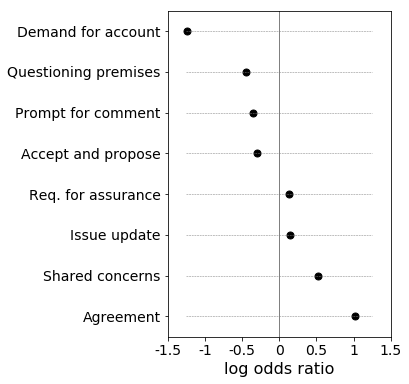

In [33]:
fig, ax = plt.subplots(figsize=(4,6))
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-.5,7.5)
for i,cname in enumerate(type_order):
    log_odds = log_odds_party_df.loc[cname].log_odds
    ax.scatter([log_odds], [i], color='black',s=49)
    ax.plot([-1.25,1.25],[i,i],'--', color='grey', linewidth=.5)
ax.plot([0,0],[-2,8], color='grey', linewidth=1)
ax.invert_yaxis()
ax.set_yticks(np.arange(len(type_order)))
ax.set_yticklabels(display_names, fontsize=14)
ax.set_xticklabels([-1.5,-1,-.5,0,.5,1,1.5], fontsize=14)
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)
ax.set_xlabel('log odds ratio', fontsize=16)
None

Here, points further to the right indicate question types more likely to be asked by government-affiliated askers; points to the left indicate types more likely to be asked by the opposition. This passes a sanity check: more aggressive questions tend to be asked more by opposition askers, while more positive, bolstering types are asked more by government askers.

To examine the relationship between question type and tenure, we compute the median tenure of askers per type. Since we know that different types might be asked more by govt vs opposition members, and since opposition members tend to be more tenured, we separate this analysis by affiliation, resulting in the plot a few cells down:

In [34]:
med_tenures = pd.concat([utt_meta_sub[utt_meta_sub.is_incumbent].groupby('fw_clustering.cluster').tenure.median().rename('govt'),
utt_meta_sub[~utt_meta_sub.is_incumbent].groupby('fw_clustering.cluster').tenure.median().rename('oppn')], axis=1)
med_in_tenure = utt_meta_sub[utt_meta_sub.is_incumbent].tenure.median()
med_op_tenure = utt_meta_sub[~utt_meta_sub.is_incumbent].tenure.median()

In [35]:
med_tenures

,govt,oppn
fw_clustering.cluster,,
accept_propose,9.997260,11.734247
agreement,4.830137,9.512329
demand_account,8.756164,8.872603
issue_update,4.852055,8.493151
prompt_comment,6.110959,8.854795
question_premises,8.679452,9.657534
request_assurance,6.461644,9.564384
shared_concern,6.917808,10.347945


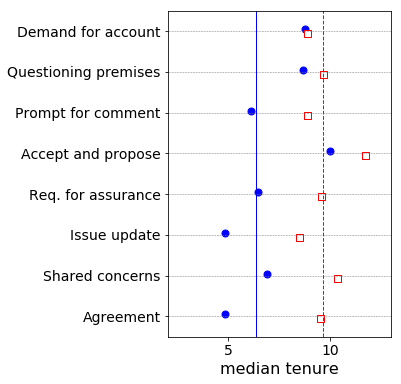

In [36]:
fig, ax = plt.subplots(figsize=(4,6))
ax.set_xlim(2, 13)
ax.set_ylim(-.5,7.5)
for i,cname in enumerate(type_order):
    ax.scatter([med_tenures.loc[cname].govt],[i-.05], s=49, color='blue')
    ax.scatter([med_tenures.loc[cname].oppn],[i+.05], s=49, color='red', facecolor='white',marker='s')
    ax.plot([.5,14.5],[i,i],'--', color='grey', linewidth=.5)
ax.plot([med_in_tenure, med_in_tenure],[-2,8], color='blue',linewidth=1)
ax.plot([med_op_tenure, med_op_tenure],[-2,8], '--', color='red', linewidth=1)
ax.invert_yaxis()
ax.set_xticks([5,10])
ax.set_xticklabels([5,10], fontsize=14)
ax.set_yticks(np.arange(8))
ax.set_yticklabels(display_names, fontsize=14)
ax.set_xlabel('median tenure', fontsize=16)
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

One interesting thing to point out is that among questions asked by government affiliated members, aggressive (e.g., **demand for account**) questions tend to be asked more by older askers (indicated by blue dots) -- that is, it seems that as parliamentarians get more tenured, they ask more aggressive questions. Note that the ministers answering these questions are almost always affiliated with the government, so this means that older askers are more aggressive, even towards members of their own party. In [this dissertation](https://tisjune.github.io/research/dissertation) we more carefully examine this observation.

## 4. Other applications of the Expected Context Framework

### Answer types

Note that we can also try to infer types of _answers_, instead of types of questions. To do this, we initialize a new Expected Context Model with some modifications to the arguments passed in: 

In [37]:
a_ec = ExpectedContextModelTransformer(
    context_field='reply_to', output_prefix='bk', 
    vect_field='arc_tfidf', context_vect_field='q_arc_tfidf',
      n_svd_dims=15, n_clusters=5,
      random_state=1000, cluster_random_state=1000)

In [38]:
a_ec.fit(parl_corpus, selector=lambda x: x.meta['is_answer'] and (x.meta.get('arc_tfidf__n_feats',0)>0),
         context_selector=lambda x: x.meta['is_question'] and (x.meta.get('q_arc_tfidf__n_feats',0)>0))

In [39]:
a_ec.print_clusters(corpus=parl_corpus)

CLUSTER 0 0
---
terms
               cluster_dist
index                      
keep_*             0.268190
clearly>*          0.278435
reviewing_are      0.279912
looking_*          0.296509
happen_*           0.302775
point_is           0.303575
looking_are        0.329829
consider_will      0.330174
look_*             0.331673
want_not           0.339141

context terms
                cluster_dist
index                       
instruct_*          0.478614
report_*            0.488451
at>*                0.497210
intervene_*         0.501445
given>*             0.513234
intervene_will      0.528936
endorse_*           0.568409
given>that          0.593500
agree_go            0.616590
to_*                0.636640


utterances
> 1989-02-15a.307.5 0.096 Government involvement in manufacturing is the last thing that the manufacturing industry wants . In fact , there is absolutely no reason why something should not be made from scratch , providing that it is competitive and is of the require

> 1993-05-17a.13.7 0.071 I take careful note of what my hon Friend says , as , no doubt , will colleagues from all parties here and in the other place who serve on the Ecclesiastical Committee , which is to meet later this afternoon and which is now the only possible source of delay . My hon Friend can be assured that the Ecclesiastical Committee will present to the House for his benefit a comprehensive summary of the arguments for and against the ordination of women , I believe with an endorsement to the effect that the measure is expedient .
> 1988-10-25a.168.1 0.074 With regard to the right hon Gentleman 's point about Piper Alpha , as he knows , that has yet to be decided . I think that there is a delegation to my hon Friend the Minister of State this afternoon to discuss the possible payment of costs on the inquiry . With regard to the IRA and the Criminal Injuries Compensation Board , I take note of his point and will pursue it .
> 2003-03-18.746.1 0.084 I take the very simple vi

We suggest that the types inferred are slightly messier than those inferred for questions, though there are still discernable interpretations:

In [40]:
a_ec.set_cluster_names(['progress_report', 'statement', 'endorsement', 'comment', 'commitment'])

In [41]:
a_ec.print_cluster_stats()

,utts,terms,context_utts,context_terms
comment,0.175944,0.201035,0.151253,0.173611
commitment,0.257680,0.209904,0.099321,0.095486
endorsement,0.125338,0.144863,0.275901,0.218750
progress_report,0.041792,0.115299,0.137177,0.154514
statement,0.399247,0.328899,0.336348,0.357639


As with question types, we'll briefly examine the relation between answer types and speaker affiliation. Here, we relate types to the affiliation of the _asker of the question_ for which the answer is provided.

In [ ]:
_ = a_ec.transform(parl_corpus, selector=lambda x: x.meta['is_answer'] and (x.meta.get('arc_tfidf__n_feats',0)>0))

In [75]:
a_utt_meta_df = parl_corpus.get_attribute_table('utterance',
                ['bk_clustering.cluster'])
a_utt_meta_sub = a_utt_meta_df.join(utt_meta_df[((utt_meta_df.is_incumbent == True) | (utt_meta_df.is_oppn == True))
                    & (utt_meta_df.speaker != '<UNKNOWN>') & (utt_meta_df.party.notnull())
                    & (utt_meta_df.govt_coarse != 'thatcher+major')].set_index('next_id'), how='inner')
a_utt_meta_sub = a_utt_meta_sub[a_utt_meta_sub['bk_clustering.cluster'].notnull()]

In [76]:
a_utt_meta_sub.shape

(84823, 11)

In [77]:
log_odds_party_answer  = []
for cname in a_ec.get_cluster_names():
    entry =  compute_log_odds(a_utt_meta_sub['bk_clustering.cluster'],a_utt_meta_sub['is_incumbent'],
                             val_subset=[cname])
    log_odds_party_answer += entry
log_odds_party_answer_df = pd.DataFrame(log_odds_party_answer).set_index('val')

In [78]:
a_type_order = log_odds_party_answer_df.sort_values('log_odds').index

In [79]:
a_display_names = ['Statement', 'Comment', 'Progress report', 'Commitment', 'Endorsement']

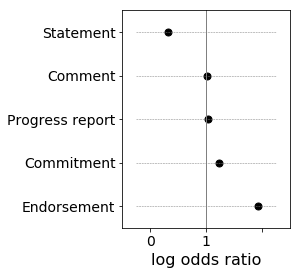

In [85]:
fig, ax = plt.subplots(figsize=(3,4))
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-.5,4.5)
for i,cname in enumerate(a_type_order):
    log_odds = log_odds_party_answer_df.loc[cname].log_odds
    ax.scatter([log_odds], [i], color='black',s=49)    
    ax.plot([-1.25,1.25],[i,i],'--', color='grey', linewidth=.5)
ax.plot([0,0],[-2,5], color='grey', linewidth=1)
ax.invert_yaxis()
ax.set_yticks(np.arange(len(a_type_order)))
ax.set_yticklabels(a_display_names, fontsize=14)
ax.set_xlabel('log odds ratio', fontsize=16)
ax.set_xticklabels([-1,0,1], fontsize=14)
None

### Ranges

We briefly examine the range statistic we computed for each utterance. Below, we plot distributions of ranges for questions of each inferred type, as box plots:

In [43]:
utt_range_df = parl_corpus.get_attribute_table('utterance',
                ['fw_clustering.cluster','fw_range'])
utt_range_df = utt_range_df[utt_range_df.fw_range.notnull()].copy()

In [44]:
fw_range_distrs = utt_range_df.groupby('fw_clustering.cluster').fw_range.describe().sort_values('50%')
med_range_full = utt_range_df.fw_range.median()

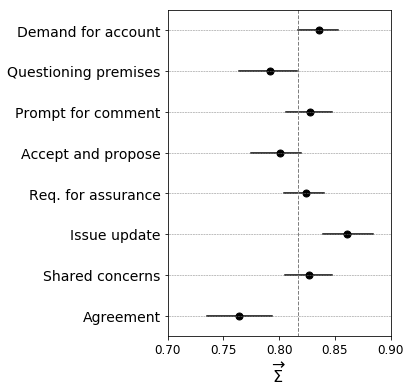

In [46]:
fig, ax = plt.subplots(figsize=(4,6))
ax.set_xlim(.7, .9)
ax.set_ylim(-.5,7.5)
for i,cname in enumerate(type_order):
    med_range = fw_range_distrs.loc[cname]['50%']
    left = fw_range_distrs.loc[cname]['25%']
    right = fw_range_distrs.loc[cname]['75%']
    ax.scatter([med_range], [i], color='black',s=49)
    ax.plot([left,right],[i,i], color='black')
    ax.plot([-1.25,1.25],[i,i],'--', color='grey', linewidth=.5)
ax.plot([med_range_full,med_range_full],[-2,8], '--', color='grey', linewidth=1)
ax.invert_yaxis()
ax.set_yticks(np.arange(len(type_order)))
ax.set_yticklabels(display_names, fontsize=14)
ax.set_xlabel('$\overrightarrow{\Sigma}$', fontsize=16)
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)


We note that the **agreement** question type tends to have lower forwards ranges than the rest, and suggest this reflects the relatively routine, formulaic nature of an exchange involving this question type ("Do you agree?" "I agree completely.")